In [0]:
#@title Default title text
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving return_2004_40.csv to return_2004_40.csv
User uploaded file "return_2004_40.csv" with length 1494219 bytes


In [8]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12
lookback = 3
chosen_stocks = ["GS"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [9]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [10]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [11]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(157, 12)


In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [14]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [29]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [30]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 2s 29ms/step - loss: 3.4734 - acc: 0.4321 - val_loss: 3.0926 - val_acc: 0.3333
Epoch 2/200
81/81 [==============================] - 0s 585us/step - loss: 2.6315 - acc: 0.4321 - val_loss: 2.7119 - val_acc: 0.3333
Epoch 3/200
81/81 [==============================] - 0s 574us/step - loss: 2.3129 - acc: 0.4321 - val_loss: 2.5146 - val_acc: 0.3333
Epoch 4/200
81/81 [==============================] - 0s 604us/step - loss: 2.1499 - acc: 0.4321 - val_loss: 2.3713 - val_acc: 0.3333
Epoch 5/200
81/81 [==============================] - 0s 549us/step - loss: 2.0197 - acc: 0.4321 - val_loss: 2.2596 - val_acc: 0.3333
Epoch 6/200
81/81 [==============================] - 0s 568us/step - loss: 1.9423 - acc: 0.4321 - val_loss: 2.1674 - val_acc: 0.3333
Epoch 7/200
81/81 [==============================] - 0s 556us/step - loss: 1.8663 - acc: 0.4321 - val_loss: 2.0890 - val_acc: 0.3333
Epoch 8/200
81/81 [=======

Epoch 62/200
81/81 [==============================] - 0s 507us/step - loss: 0.6915 - acc: 0.5432 - val_loss: 0.7092 - val_acc: 0.4167
Epoch 63/200
81/81 [==============================] - 0s 526us/step - loss: 0.7112 - acc: 0.4568 - val_loss: 0.7035 - val_acc: 0.4722
Epoch 64/200
81/81 [==============================] - 0s 528us/step - loss: 0.7259 - acc: 0.4815 - val_loss: 0.6989 - val_acc: 0.5833
Epoch 65/200
81/81 [==============================] - 0s 726us/step - loss: 0.6950 - acc: 0.5309 - val_loss: 0.6949 - val_acc: 0.6111
Epoch 66/200
81/81 [==============================] - 0s 844us/step - loss: 0.6962 - acc: 0.5185 - val_loss: 0.6917 - val_acc: 0.6389
Epoch 67/200
81/81 [==============================] - 0s 765us/step - loss: 0.6987 - acc: 0.5309 - val_loss: 0.6888 - val_acc: 0.6667
Epoch 68/200
81/81 [==============================] - 0s 800us/step - loss: 0.6904 - acc: 0.5432 - val_loss: 0.6868 - val_acc: 0.6667
Epoch 69/200
81/81 [==============================] - 0s 517us

Epoch 123/200
81/81 [==============================] - 0s 525us/step - loss: 0.6922 - acc: 0.5926 - val_loss: 0.6777 - val_acc: 0.6667
Epoch 124/200
81/81 [==============================] - 0s 519us/step - loss: 0.6769 - acc: 0.6049 - val_loss: 0.6770 - val_acc: 0.6667
Epoch 125/200
81/81 [==============================] - 0s 515us/step - loss: 0.6857 - acc: 0.5679 - val_loss: 0.6770 - val_acc: 0.6667
Epoch 126/200
81/81 [==============================] - 0s 515us/step - loss: 0.6910 - acc: 0.5309 - val_loss: 0.6770 - val_acc: 0.6667
Epoch 127/200
81/81 [==============================] - 0s 535us/step - loss: 0.6819 - acc: 0.5556 - val_loss: 0.6767 - val_acc: 0.6667
Epoch 128/200
81/81 [==============================] - 0s 655us/step - loss: 0.6938 - acc: 0.5556 - val_loss: 0.6767 - val_acc: 0.6667
Epoch 129/200
81/81 [==============================] - 0s 542us/step - loss: 0.7040 - acc: 0.5556 - val_loss: 0.6765 - val_acc: 0.6667
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 558us/step - loss: 0.6802 - acc: 0.6173 - val_loss: 0.6747 - val_acc: 0.6667
Epoch 185/200
81/81 [==============================] - 0s 558us/step - loss: 0.6836 - acc: 0.5556 - val_loss: 0.6747 - val_acc: 0.6667
Epoch 186/200
81/81 [==============================] - 0s 541us/step - loss: 0.6953 - acc: 0.5926 - val_loss: 0.6742 - val_acc: 0.6667
Epoch 187/200
81/81 [==============================] - 0s 527us/step - loss: 0.6936 - acc: 0.5926 - val_loss: 0.6740 - val_acc: 0.6667
Epoch 188/200
81/81 [==============================] - 0s 529us/step - loss: 0.6824 - acc: 0.5802 - val_loss: 0.6735 - val_acc: 0.6667
Epoch 189/200
81/81 [==============================] - 0s 538us/step - loss: 0.7029 - acc: 0.5802 - val_loss: 0.6734 - val_acc: 0.6667
Epoch 190/200
81/81 [==============================] - 0s 533us/step - loss: 0.6908 - acc: 0.5679 - val_loss: 0.6736 - val_acc: 0.6667
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 237us/step
loss: 0.6907483339309692
acc: 0.5384615659713745


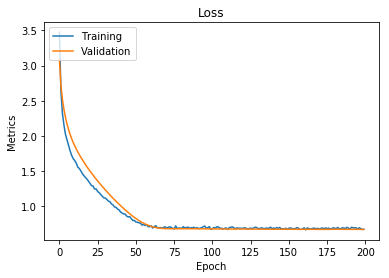

In [31]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [33]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.56653774]
 [0.53969437]
 [0.5064615 ]
 [0.55630136]
 [0.5667262 ]
 [0.55900276]
 [0.5606319 ]
 [0.56749123]
 [0.53871036]
 [0.5071217 ]
 [0.51616704]
 [0.5303634 ]
 [0.52287483]
 [0.4980864 ]
 [0.49181396]
 [0.47283018]
 [0.48693877]
 [0.5206561 ]
 [0.5076249 ]
 [0.50872064]
 [0.5622761 ]
 [0.54465675]
 [0.5701835 ]
 [0.6108758 ]
 [0.6469806 ]
 [0.59423864]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0       0.54      1.00      0.70        14

avg / total       0.29      0.54      0.38        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0       0.54      1.00      0.70        14

avg / total       0.29      0.54      0.38        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
import math

buy_list = []
sell_list = []

midpt = (max(map(lambda x: x[0], result)) + min(map(lambda x: x[0], result))) / 2

for i, r in enumerate(result):
  buy_or_sell = 1 if r.item() > midpt * 1 else (-1 if r.item() < midpt * 0.9 else 0)
  if r.item() > midpt * 1.1:
    buy_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  if r.item() < midpt * 0.9:
    sell_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  print(str(y_test[i].item()) + ": " + str(buy_or_sell))
  if (math.fabs(buy_or_sell - y_test[i].item()) == 2) or (buy_or_sell - y_test[i].item() == 1):
    print("Hey")
print(buy_list)
print(sell_list)

1.0: 1
0.0: 0
1.0: 0
1.0: 0
1.0: 1
0.0: 0
0.0: 1
Hey
0.0: 1
Hey
1.0: 0
1.0: 0
0.0: 0
0.0: 0
0.0: 0
1.0: -1
Hey
1.0: -1
Hey
0.0: -1
0.0: -1
1.0: 0
1.0: 0
0.0: 0
1.0: 1
1.0: 0
1.0: 1
0.0: 1
Hey
1.0: 1
0.0: 1
Hey
[{'month_id': 247, 'QAId': 'GS'}]
[{'month_id': 236, 'QAId': 'GS'}, {'month_id': 237, 'QAId': 'GS'}, {'month_id': 238, 'QAId': 'GS'}, {'month_id': 239, 'QAId': 'GS'}]


In [39]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)
dfSell.head(5)

,month_id,QAId
0,236,GS
1,237,GS
2,238,GS
3,239,GS


In [42]:
# from google.colab import files

filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)